In [15]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

In [34]:
orig_img = cv2.imread("assets/images/photo_2025-05-27_17-01-25.jpg")
orig_img = cv2.cvtColor(orig_img, cv2.COLOR_BGR2RGB)
seg_mask = cv2.imread("assets/results/resnet34/photo_2025-05-27_17-01-25.png")
seg_mask = cv2.cvtColor(seg_mask, cv2.COLOR_BGR2GRAY)

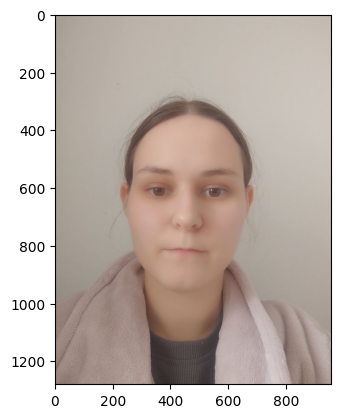

In [35]:
plt.imshow(orig_img)

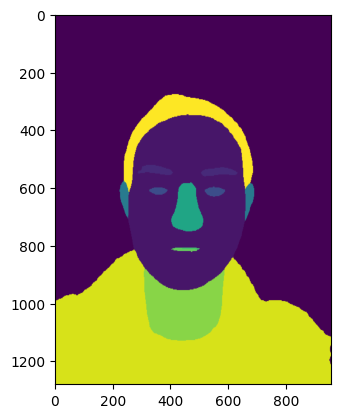

In [36]:
plt.imshow(seg_mask)

In [37]:
np.unique(seg_mask)

array([ 0,  1,  2,  4,  7, 10, 12, 13, 14, 16, 17], dtype=uint8)

In [40]:
seg_mask_mouth = seg_mask.copy()
seg_mask_left_eye = seg_mask.copy()
seg_mask_right_eye = seg_mask.copy()
seg_mask_face = seg_mask.copy()

seg_mask_left_eye[seg_mask_left_eye!=4] = 0
seg_mask_right_eye[seg_mask_right_eye!=5] = 0

seg_mask_mouth[(seg_mask_mouth!=11) & (seg_mask_mouth!=12) & (seg_mask_mouth!=13)] = 0

seg_mask_face[seg_mask_face!=1] = 0


In [41]:
def find_part_rect(part_seg_mask):
    cnt, _ = cv2.findContours(part_seg_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    if len(cnt) < 1:
        return np.asarray([0,0,0,0])
    print(cnt[0].min(axis=0), cnt[0].max(axis=0))
    return np.asarray(cv2.boundingRect(cnt[0][:,0,:]))

In [42]:
left_eye_rect = find_part_rect(seg_mask_left_eye)
right_eye_rect = find_part_rect(seg_mask_right_eye)
mouth_rect = find_part_rect(seg_mask_mouth)
face_rect = find_part_rect(seg_mask_face)

[[326 600]] [[388 624]]
[[402 808]] [[499 822]]
[[253 347]] [[658 954]]


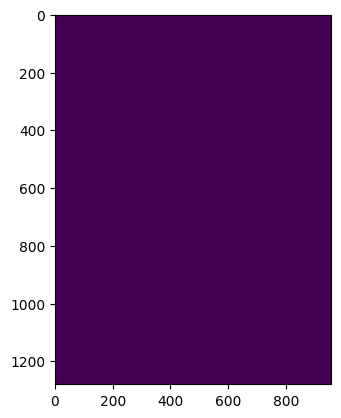

In [43]:
plt.imshow(seg_mask_right_eye)

In [23]:
img = orig_img.copy()
img = cv2.rectangle(img.copy(), left_eye_rect[0:2],  left_eye_rect[0:2]+left_eye_rect[2:4],
                    color=(255,255,0), thickness=6)

img = cv2.rectangle(img.copy(), right_eye_rect[0:2],  right_eye_rect[0:2]+right_eye_rect[2:4],
                    color=(255,255,0), thickness=6)

img = cv2.rectangle(img.copy(), mouth_rect[0:2],  mouth_rect[0:2]+mouth_rect[2:4],
                    color=(255,0,255), thickness=6)

img = cv2.rectangle(img.copy(), face_rect[0:2],  face_rect[0:2]+face_rect[2:4],
                    color=(0,0,255), thickness=6)

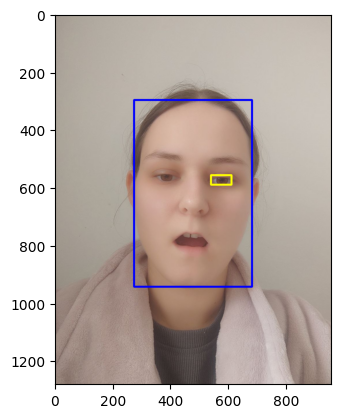

In [24]:
plt.imshow(img)

In [25]:
def adjust_eye_rects_by_face(face_rect, left_eye_raw_rect, right_eye_raw_rect, img_shape):
    fx, fy, fw, fh = face_rect
    img_h, img_w = img_shape[:2]

    target_eye_width = int(fw / 5.0) 
    target_eye_height = int(target_eye_width * 0.6) 

    adjusted_left_eye = np.copy(left_eye_raw_rect)
    adjusted_right_eye = np.copy(right_eye_raw_rect)

    if left_eye_raw_rect[2] > 0 and left_eye_raw_rect[3] > 0: 
        lx, ly, lw, lh = left_eye_raw_rect

        center_lx = lx + lw // 2
        center_ly = ly + lh // 2

        adjusted_left_eye[0] = max(0, center_lx - target_eye_width // 2)
        adjusted_left_eye[1] = max(0, center_ly - target_eye_height // 2)
        adjusted_left_eye[2] = target_eye_width
        adjusted_left_eye[3] = target_eye_height

    if right_eye_raw_rect[2] > 0 and right_eye_raw_rect[3] > 0: 
        rx, ry, rw, rh = right_eye_raw_rect

        center_rx = rx + rw // 2
        center_ry = ry + rh // 2

        adjusted_right_eye[0] = max(0, center_rx - target_eye_width // 2)
        adjusted_right_eye[1] = max(0, center_ry - target_eye_height // 2)
        adjusted_right_eye[2] = target_eye_width
        adjusted_right_eye[3] = target_eye_height


    for rect in [adjusted_left_eye, adjusted_right_eye]:
        x, y, w, h = rect
        if x + w > img_w:
            rect[2] = img_w - x
        if y + h > img_h:
            rect[3] = img_h - y
        rect[0] = max(0, rect[0])
        rect[1] = max(0, rect[1])
        rect[2] = max(0, rect[2]) 
        rect[3] = max(0, rect[3])


    return adjusted_left_eye, adjusted_right_eye

In [26]:
img_height, img_width = img.shape[:2]

left_eye_rect_full, right_eye_rect_full = adjust_eye_rects_by_face(
    face_rect, left_eye_rect, right_eye_rect, img.shape
)


In [38]:
img = orig_img.copy()
img = cv2.rectangle(img.copy(), left_eye_rect_full[0:2],  left_eye_rect_full[0:2]+left_eye_rect_full[2:4],
                    color=(255,255,0), thickness=6)

img = cv2.rectangle(img.copy(), right_eye_rect_full[0:2],  right_eye_rect_full[0:2]+right_eye_rect_full[2:4],
                    color=(255,255,0), thickness=6)

img = cv2.rectangle(img.copy(), mouth_rect[0:2],  mouth_rect[0:2]+mouth_rect[2:4],
                    color=(255,0,255), thickness=6)

img = cv2.rectangle(img.copy(), face_rect[0:2],  face_rect[0:2]+face_rect[2:4],
                    color=(0,0,255), thickness=6)

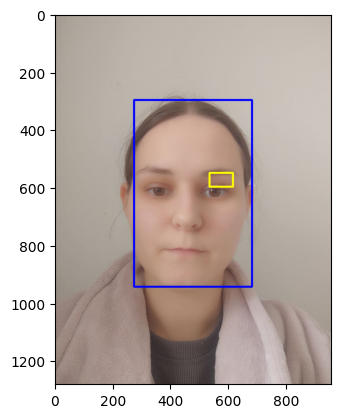

In [39]:
plt.imshow(img)